# Imports and Data

In [75]:
from typing import NamedTuple
import pandas as pd
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import lru_cache


class CollegeMessage(NamedTuple):
    source: int  #source id
    target: int  # target id
    unix_timestamp: int  # seconds after last epoc


def read_message_data(datapath: str) -> list[CollegeMessage]:
    filepath = Path.cwd() / Path(datapath)

    if not filepath.exists():
        raise FileNotFoundError(
            f"File not found: {filepath}; " +
            f"Current working directory: {Path.cwd()}; " +
            f"Relative path to data file: {Path(datapath)}"
        )

    print(f"Using file: {filepath.absolute()}")

    messages = []
    with open(filepath, 'r', encoding="UTF-8") as f:
        for line in f:
            source, target, timestamp = line.strip().split()
            messages.append(CollegeMessage(int(source), int(target), int(timestamp)))
    print("done")
    return messages


def remove_low_degree_nodes(data: pd.DataFrame, min_degree: int) -> pd.DataFrame:
    in_degree = data['target'].value_counts()
    out_degree = data['source'].value_counts()
    high_degree_nodes = set(in_degree[in_degree >= min_degree].index) & set(out_degree[out_degree >= min_degree].index)
    return data[data['source'].isin(high_degree_nodes) & data['target'].isin(high_degree_nodes)]


def create_graph(data: pd.DataFrame) -> nx.DiGraph:
    digraph = nx.DiGraph()

    for row in data.itertuples(index=False):
        digraph.add_edge(row.source, row.target, timestamp=row.unix_timestamp)

    return digraph


def graph_figure(graph: nx.DiGraph):
    pos = nx.arf_layout(graph)
    nx.draw(graph, pos, with_labels=False, node_size=10)

In [60]:
_DATA_PATH = "./dataset/CollegeMsg.txt"

_MESSAGES = read_message_data(_DATA_PATH)

DF_MESSAGES = remove_low_degree_nodes(pd.DataFrame(_MESSAGES), 2)

GRAPH_MESSAGES = create_graph(DF_MESSAGES)

Using file: /home/mojmir-majer/projects/private/github/rug-sna-pizza-giving/college_msg_files/dataset/CollegeMsg.txt
done


In [61]:
DF_MESSAGES.head()

,source,target,unix_timestamp
39,41,42,1082574211
48,36,50,1082597715
49,44,51,1082597751
50,32,52,1082598056
51,36,32,1082598122


# Time window

In [76]:
def time_window(graph: nx.DiGraph, unix_start: int, unix_end: int) -> nx.DiGraph:
    return graph.edge_subgraph([
        (source, target)
        for source, target, timestamp in graph.edges(data='timestamp')
        if unix_start <= timestamp <= unix_end
    ])


def export_graph(
        graph: nx.DiGraph,
        pos: dict,
        export_path: str = None
):
    nx.draw(graph, pos=pos, with_labels=False, node_size=10)

    if export_path:
        plt.savefig(export_path)


def export_time_windows(pos: dict):
    start_unix_timestamp = DF_MESSAGES['unix_timestamp'].min()
    end_unix_timestamp = DF_MESSAGES['unix_timestamp'].max()

    # todo all days
    # start_datetime = pd.to_datetime(start_unix_timestamp)
    # end_datetime = pd.to_datetime(end_unix_timestamp)
    # days = (start_datetime - end_datetime).days
    total = 14

    day_in_seconds = 60 * 60 * 24

    timeframes = (
        start_unix_timestamp + day_in_seconds * i
        for i in range(0, total)
    )

    # graphs for timeframes
    subgraphs = (
        time_window(GRAPH_MESSAGES, timeframe, timeframe + day_in_seconds)
        for timeframe in timeframes
    )

    for i, graph in tqdm(enumerate(subgraphs), total=total):
        export_graph(graph, pos, f"./.export/graph_{i}.png")
        
# Layout calculations, cached by LRU to avoid recalculating the layout
@lru_cache(maxsize=None)
def cache_layout(graph: nx.DiGraph, layout_func: callable):
    print("Calculating layout ...")
    layout = layout_func(graph)
    print("... done calculating layout")
    return layout

100%|██████████| 14/14 [00:40<00:00,  2.90s/it]


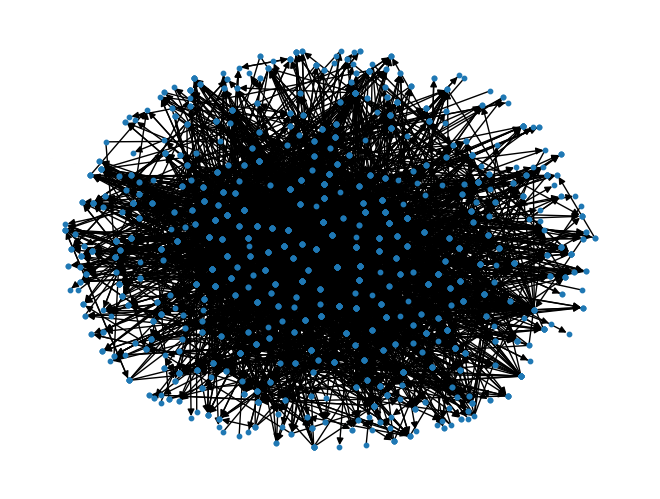

In [73]:
export_time_windows(cache_layout(GRAPH_MESSAGES, nx.spring_layout))